Import important functions. 

In [15]:
from __future__ import print_function, division 
import os 
import torch 
import torch.nn as nn # for definition of network 
import torch.optim as optim # for optimizazion of network 
import torch.nn.functional as F # for loss function 
from torch.utils.data import DataLoader # for loading data 
from torch.autograd import Variable 
from torchvision import datasets, transforms

Use the following command to get the results faster and using GPU (In case your GPU supports cuda)

In [16]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
cudnn.fastest = True

In [17]:
import matplotlib.pyplot as plt # to plot loss

In [18]:
import timeit

Set the global parameters used to acquire train and test data as well as optimization parameters.

In [19]:
# Define parameters
BATCH_SIZE = 50
EPOCHS = 60
DATA_DIR = '/Users/nayansavaliya/Masters Mechatronics/2022 Summer/RAML - Project/data/all'
LEARNING_RATE = 0.001
IMAGE_SIZE = [32, 32]

In [20]:
# for plots
LOSS_ARRAY = []
TEST_ACCURACY = []

Compute mean of the train dataset in order to zero center the both of train and test dataset

In [21]:
data_transforms_1 = {
    'train': transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])}

train_dataset_1 = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), data_transforms_1['train'])
train_images = torch.stack([t for t, c in train_dataset_1])
mean_train_images = train_images.mean(0)

Load the train and test data, apply random flip for "jittering" the train data. 

In [22]:
data_transforms = {
    'train': transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]),
    'test': transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])}
    
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), data_transforms['test'])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,shuffle=True)

print(train_loader.__len__()*train_loader.batch_size, 'train samples')
print(test_loader.__len__()*test_loader.batch_size, 'test samples\n')

3200 train samples
800 test samples



Define the "regularized" network 

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 15, kernel_size=9, stride=1, padding=0, bias=True)# 1 input and 15 output layers
        
        self.maxpool1 = nn.MaxPool2d(2, stride=1, padding=0)
        
        self.dropout = nn.Dropout2d(p=0.5, inplace=False)
        
        self.conv2 = nn.Conv2d(15, 20, kernel_size=5, stride=1, padding=2, bias=True)
        
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(20, 20, kernel_size=5, stride=1, padding=2, bias=True)
        
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=0)
        
        self.fc1 = nn.Linear(5*5*20, 1)
        self.fc0 = nn.Linear(16*16,1)
        self.fc01 = nn.Linear(32*32,16*16)

    def forward(self, x):
        # define the acutal network
        in_size = x.size(0) # this is the batch size
        x=torch.abs(torch.fft.fft2(x))
        x=torch.log(x)
        x = x.view(in_size, -1)
        x = self.fc01(x)
        x = F.relu(x)
        x = self.fc0(x)
        x = torch.sigmoid(x)
        return x#F.softmax(x, dim=0)

    def forwardc(self, x):
        # define the acutal network
        in_size = x.size(0) # this is the batch size
        x=torch.abs(torch.fft.fft2(x))
        x=torch.log(x+1)
        x = self.conv1(x)
        #x = self.maxpool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = F.relu(x)
        #x = self.dropout(x)
        x = x.view(in_size, -1) #flatten data
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x#F.softmax(x, dim=0)

Initialization of the model and adding the definition of the optimizer. Optimizer is defined based on Stochastic Gradient Descent method with momentum and predefined learning rate for updating the parameters.

In [24]:
net = Net()
#net.cuda()    # this is the only line necessary to make your model run on GPU

optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)

Loop over the train data. In each iteration (epoch) the whole train dataset is passed through the network and based on the loss function and optimization algorithm the initialized values for the parameters are updated. 

Also, in order to zero center the data at each iteration, the computed mean image is subtracted from the train data.

In [25]:
def train(epoch):

    net.train() 

    for batch_idx, (data, target) in enumerate(train_loader):
        
        for i in range(0,BATCH_SIZE):
            data[i,:,:,:] = data[i,:,:,:] - mean_train_images
       
        #data, target = Variable(data.cuda()), Variable(target.cuda())  
        data, target = Variable(data),Variable(target)
        # reduce the learning rate by a factor of 10 in every 50 epochs
        lr = LEARNING_RATE * (0.1 ** (epoch // 50))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        optimizer.zero_grad() # necessary for new sum of gradients
        output = net(data)  # call the forward() function (forward pass of network)
        lossf=nn.BCELoss()
        #loss = F.nll_loss(output, target) # use negative log likelihood to determine loss
        loss=lossf(torch.squeeze(output.float()),torch.squeeze(target.float()))
        loss.backward() # backward pass of network (calculate sum of gradients for graph)
        optimizer.step() # perform model parameter update (update weights)
        
        # for graphing puposes
        LOSS_ARRAY.append(loss.item())
        
        # print the current status of training
        print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
             epoch, batch_idx * len(data), len(train_loader.dataset),
             100. * batch_idx / len(train_loader), loss.item()))

Loop over the test data, just to evaluate how our network works for unseen data. In this stage only data goes forward in the network and none of the parameters are updated

In [26]:
# the test function
def test(epoch):
    net.eval()  
    test_loss = 0
    correct = 0

    for data, target in test_loader:
        
        for i in range(0,data.size(0)):
            data[i,:,:,:] = data[i,:,:,:] - mean_train_images
       
        #data, target = Variable(data.cuda(), volatile=True), Variable(target.cuda()) 
        data, target = Variable(data, volatile = True), Variable(target)     
        output = net(data)
        lossf=nn.BCELoss()
        test_loss += lossf(torch.squeeze(output.float()),torch.squeeze(target.float())).item()#F.nll_loss(output, target, size_average=False).data[0] 
        pred = output.data.max(1, keepdim=True)[1]
        pred = torch.round(output.data)
        correct+= pred.eq(target.data.view_as(pred)).cpu().sum() 
       
    test_dat_len = len(test_loader.dataset)
    test_loss /= test_dat_len
    
    # print the test accuracy
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, test_dat_len, 100. * correct / test_dat_len))

    TEST_ACCURACY.append(correct / test_dat_len)

For each epoch, call the train and test functions to update the parameters and evaluate the network

ValueError: x and y can be no greater than 2D, but have shapes (50,) and torch.Size([50, 1, 32, 32])

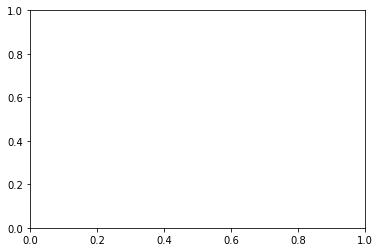

In [27]:
for epoch in range(1,EPOCHS):
        start_time = timeit.default_timer()
   
        train(epoch)
    
        test(epoch)
    
        elapsed = timeit.default_timer() - start_time
        
        print("Epoch time is", elapsed, "s\n")

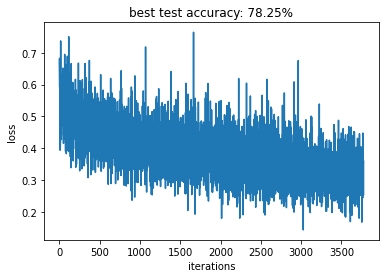

In [ ]:
#plot loss
plt.plot(LOSS_ARRAY)
plt.title('best test accuracy: {:.2f}%'.format(100*max(TEST_ACCURACY)))
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

Reference:
https://codetolight.wordpress.com/2017/11/29/getting-started-with-pytorch-for-deep-learning-part-3-neural-network-basics/